In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from sklearn.metrics import accuracy_score

In [2]:
# загрузка датасета
DF = pd.read_excel('data.xlsx') 

In [3]:
DF

,Loan issued,Рейтинг,"Comission, %",Earned interest,"Unpaid, full amount",EL,учредителю подсказывают / на ВИ другой человек,"На ВИ присутствует ""сотрудник"", в тч за кадром, который отвечает на вопросы","""Сотрудник"" отвечает на вопросы. ГД/учредитель молчит или отвечает редко.",В компании была смена учредителя,...,"Не знает наценку (рентабельность, прибыль)","Не знает кредиторов ), в тч объем обязательств",Нерелевантный опыт работы,Нелогичный выбор сферы бизнеса,За ответом на вопросы 10-14 просит обратиться к сотруднику,Данные предоставленные заемщиком разнятся с действительностью > 50%,"Есть ""партнер"", который официально не оформлен","Не потребовалось денег для начала бизнеса, тк были договоренности с поставщиками","Офис находится в здании партнера/друга/родственника, аренду не платит.",Заемщик от партнера и был подготовлен к ВИ
0,3 170 000 ₽,7,0.0530,211 051 ₽,862 850 ₽,0.015,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,500 000 ₽,17,0.0650,39 518 ₽,289 518 ₽,0.100,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
2,11 600 897 ₽,9,0.0450,537 680 ₽,9 567 386 ₽,0.015,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,5 250 000 ₽,13,0.0450,233 022 ₽,2 858 022 ₽,0.015,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
4,3 000 000 ₽,8,0.0375,216 485 ₽,0 ₽,0.000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
527,3 000 000 ₽,17,0.0680,83 062 ₽,3 206 436 ₽,0.015,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
528,6 560 000 ₽,10,0.0530,250 635 ₽,4 309 425 ₽,0.015,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
529,2 844 671 ₽,14,0.0550,233 514 ₽,1 064 981 ₽,0.400,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
530,500 000 ₽,12,0.0550,13 235 ₽,414 705 ₽,0.015,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


Мы имеем задачу бинарной классификации.
Цель: максимизировать совокупную экономическую прибыль, отбирая самые выгодные займы.
Модель обучится на данных о различных факторах и на выходе будет выдавать принадлежность к одной из категорий: 
0 (потенциально невыгодный заем) или 1 (потенциально выгодный заем)

#### data preprocessing

In [4]:
# проверяем тип столбцов - численный или нет
DF.dtypes

Loan issued                                                                          object
Рейтинг                                                                               int64
Comission, %                                                                        float64
Earned interest                                                                      object
Unpaid,  full amount                                                                 object
EL                                                                                  float64
учредителю подсказывают / на ВИ другой человек                                        int64
На ВИ присутствует "сотрудник", в тч за кадром, который отвечает на вопросы           int64
"Сотрудник" отвечает на вопросы. ГД/учредитель молчит или отвечает редко.             int64
В компании была смена учредителя                                                      int64
учредитель женщина                                                              

In [5]:
# функция, которая удаляет нечисловые символы и конвертирует object в int 
def from_object_to_int(series):
    series = series.str.replace('₽', '')
    series = series.str.replace('\xa0', '')
    series = series.astype('int')
    return series

In [6]:
DF['Loan issued'] = from_object_to_int(DF['Loan issued'])
DF['Earned interest'] = from_object_to_int(DF['Earned interest'])
DF['Unpaid,  full amount'] = from_object_to_int(DF['Unpaid,  full amount'])

In [7]:
# создаем новые колонки, следуя формулам:
DF['loss'] = DF['Unpaid,  full amount'] * DF['EL']                                #Loss = Unpaid * (EL, expected loss)
DF['InvestorProfit'] = DF['Earned interest'] - DF['loss']                         #InvestorProfit = Earned — Loss
DF['Profit'] = DF['InvestorProfit']+DF['Comission, %']*DF['Unpaid,  full amount'] #Profit = InvestorProfit + Commission
DF['Profit,%'] = DF['Profit']/DF['Loan issued']                                   #Profit,% = Profit / LoanIssued

In [8]:
DF

,Loan issued,Рейтинг,"Comission, %",Earned interest,"Unpaid, full amount",EL,учредителю подсказывают / на ВИ другой человек,"На ВИ присутствует ""сотрудник"", в тч за кадром, который отвечает на вопросы","""Сотрудник"" отвечает на вопросы. ГД/учредитель молчит или отвечает редко.",В компании была смена учредителя,...,За ответом на вопросы 10-14 просит обратиться к сотруднику,Данные предоставленные заемщиком разнятся с действительностью > 50%,"Есть ""партнер"", который официально не оформлен","Не потребовалось денег для начала бизнеса, тк были договоренности с поставщиками","Офис находится в здании партнера/друга/родственника, аренду не платит.",Заемщик от партнера и был подготовлен к ВИ,loss,InvestorProfit,Profit,"Profit,%"
0,3170000,7,0.0530,211051,862850,0.015,0,0,0,0,...,0,0,0,0,0,0,12942.750,198108.250,243839.300,0.076921
1,500000,17,0.0650,39518,289518,0.100,0,0,0,0,...,0,0,0,0,0,0,28951.800,10566.200,29384.870,0.058770
2,11600897,9,0.0450,537680,9567386,0.015,0,0,0,1,...,0,0,0,0,0,0,143510.790,394169.210,824701.580,0.071089
3,5250000,13,0.0450,233022,2858022,0.015,0,0,0,0,...,0,0,1,0,0,0,42870.330,190151.670,318762.660,0.060717
4,3000000,8,0.0375,216485,0,0.000,0,0,0,0,...,0,0,0,0,0,0,0.000,216485.000,216485.000,0.072162
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
527,3000000,17,0.0680,83062,3206436,0.015,0,0,0,0,...,0,0,0,0,0,0,48096.540,34965.460,253003.108,0.084334
528,6560000,10,0.0530,250635,4309425,0.015,0,0,0,0,...,0,0,0,0,0,0,64641.375,185993.625,414393.150,0.063170
529,2844671,14,0.0550,233514,1064981,0.400,0,0,0,0,...,0,0,0,0,0,0,425992.400,-192478.400,-133904.445,-0.047072
530,500000,12,0.0550,13235,414705,0.015,0,0,0,0,...,0,0,0,0,0,0,6220.575,7014.425,29823.200,0.059646


In [9]:
# будем считать займ достаточно прибыльным если его профит (profit,%) больше чем медианное значение. 
# Таким образом разделяем датасет на две равные части
median = DF['Profit,%'].median() 
print(median)

0.06329484375


In [10]:
# функция для разметки данных
f = lambda x: 1 if x > median else 0 
DF['label'] = list(map(f,DF['Profit,%']))

In [11]:
DF

,Loan issued,Рейтинг,"Comission, %",Earned interest,"Unpaid, full amount",EL,учредителю подсказывают / на ВИ другой человек,"На ВИ присутствует ""сотрудник"", в тч за кадром, который отвечает на вопросы","""Сотрудник"" отвечает на вопросы. ГД/учредитель молчит или отвечает редко.",В компании была смена учредителя,...,Данные предоставленные заемщиком разнятся с действительностью > 50%,"Есть ""партнер"", который официально не оформлен","Не потребовалось денег для начала бизнеса, тк были договоренности с поставщиками","Офис находится в здании партнера/друга/родственника, аренду не платит.",Заемщик от партнера и был подготовлен к ВИ,loss,InvestorProfit,Profit,"Profit,%",label
0,3170000,7,0.0530,211051,862850,0.015,0,0,0,0,...,0,0,0,0,0,12942.750,198108.250,243839.300,0.076921,1
1,500000,17,0.0650,39518,289518,0.100,0,0,0,0,...,0,0,0,0,0,28951.800,10566.200,29384.870,0.058770,0
2,11600897,9,0.0450,537680,9567386,0.015,0,0,0,1,...,0,0,0,0,0,143510.790,394169.210,824701.580,0.071089,1
3,5250000,13,0.0450,233022,2858022,0.015,0,0,0,0,...,0,1,0,0,0,42870.330,190151.670,318762.660,0.060717,0
4,3000000,8,0.0375,216485,0,0.000,0,0,0,0,...,0,0,0,0,0,0.000,216485.000,216485.000,0.072162,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
527,3000000,17,0.0680,83062,3206436,0.015,0,0,0,0,...,0,0,0,0,0,48096.540,34965.460,253003.108,0.084334,1
528,6560000,10,0.0530,250635,4309425,0.015,0,0,0,0,...,0,0,0,0,0,64641.375,185993.625,414393.150,0.063170,0
529,2844671,14,0.0550,233514,1064981,0.400,0,0,0,0,...,0,0,0,0,0,425992.400,-192478.400,-133904.445,-0.047072,0
530,500000,12,0.0550,13235,414705,0.015,0,0,0,0,...,0,0,0,0,0,6220.575,7014.425,29823.200,0.059646,0


In [12]:
DF.columns

Index(['Loan issued', 'Рейтинг', 'Comission, %', 'Earned interest',
       'Unpaid,  full amount', 'EL',
       'учредителю подсказывают / на ВИ другой человек',
       'На ВИ присутствует "сотрудник", в тч за кадром, который отвечает на вопросы',
       '"Сотрудник" отвечает на вопросы. ГД/учредитель молчит или отвечает редко.',
       'В компании была смена учредителя', 'учредитель женщина', 'Первое ЮЛ',
       'Выручка компании в первый год > 30 млн.',
       'Текущее ЮЛ основано до 30 лет', 'КИ учредителя < 1 млн',
       'Не знает объем выручки', 'Не знает ФОТ', 'Не знает контрагентов',
       'Не знает наценку (рентабельность, прибыль)',
       'Не знает кредиторов ), в тч объем обязательств',
       'Нерелевантный опыт работы', 'Нелогичный выбор сферы бизнеса',
       'За ответом на вопросы 10-14 просит обратиться к сотруднику',
       'Данные предоставленные заемщиком разнятся с действительностью > 50%',
       'Есть "партнер", который официально не оформлен',
       'Не потреб

In [13]:
# переименовываем столбцы с длинными названиями факторов
DF = DF.rename(columns={'Рейтинг': 'rating', 
                        'учредителю подсказывают / на ВИ другой человек':'f1',
                       'На ВИ присутствует "сотрудник", в тч за кадром, который отвечает на вопросы':'f2',
                       '"Сотрудник" отвечает на вопросы. ГД/учредитель молчит или отвечает редко.':'f3',
                       'В компании была смена учредителя':'f4',
                       'учредитель женщина':'f5',
                       'Первое ЮЛ':'f6',
                       'Выручка компании в первый год > 30 млн.':'f7',
                       'Текущее ЮЛ основано до 30 лет':'f8',
                       'КИ учредителя < 1 млн':'f9',
                       'Не знает объем выручки':'f10',
                       'Не знает ФОТ':'f11',
                       'Не знает контрагентов':'f12',
                       'Не знает наценку (рентабельность, прибыль)':'f13',
                       'Не знает кредиторов ), в тч объем обязательств':'f14',
                        'Нерелевантный опыт работы':'f15', 
                        'Нелогичный выбор сферы бизнеса':'f16',
                        'За ответом на вопросы 10-14 просит обратиться к сотруднику':'f17',
                        'Данные предоставленные заемщиком разнятся с действительностью > 50%':'f18',
                        'Есть "партнер", который официально не оформлен':'f19',
                        'Не потребовалось денег для начала бизнеса, тк были договоренности с поставщиками':'f20',
                        'Офис находится в здании партнера/друга/родственника, аренду не платит.':'f21',
                        'Заемщик от партнера и был подготовлен к ВИ':'f22'})

In [14]:
# разделяем входные данные и метки
x = DF.drop(columns=['Loan issued','rating','Comission, %', 'Earned interest',
       'Unpaid,  full amount', 'EL','loss', 'InvestorProfit', 'Profit',
       'Profit,%', 'label'],axis=1)
y = DF['label']

In [15]:
x

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22
0,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,1,0,1,0,0,...,0,0,1,1,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
527,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
528,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
529,0,0,0,0,0,0,0,1,1,0,...,0,0,1,0,0,0,0,0,0,0
530,0,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0


In [16]:
# делим данные на 3 выборки: train (тренировочная), test (валидационная) и check (проверочная)
x_check = x[-15:]
y_check = y[-15:]
X = x[:-15]
Y = y[:-15]

X_train, X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.1,stratify=Y,random_state=2)
print(X_train.shape, X_test.shape,x_check.shape)

(465, 22) (52, 22) (15, 22)


#### model building 

первая модель - Support Vector Machine

In [17]:
sv1 = svm.SVC(kernel='linear')
sv1.fit(X_train,Y_train)

SVC(kernel='linear')

In [18]:
# так как датасет сбалансирован, мы можем использовать метрику accuracy
# accuracy на обучающей выборке
X_train_pred_sv1 = sv1.predict(X_train)
train_accuracy_sv1 = accuracy_score(X_train_pred_sv1,Y_train)
print('Accuracy on training data : ', train_accuracy_sv1)

Accuracy on training data :  0.6021505376344086


In [19]:
# accuracy на тестовой выборке
X_test_pred_sv1 = sv1.predict(X_test)
test_accuracy_sv1 = accuracy_score(X_test_pred_sv1,Y_test)
print('Accuracy on test data : ', test_accuracy_sv1)

Accuracy on test data :  0.5192307692307693


In [20]:
# предсказанные моделью значения
pred_sv1 = sv1.predict(x_check)
pred_sv1

array([1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0], dtype=int64)

In [21]:
#настоящие данные
np.array(y_check)

array([1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1], dtype=int64)

In [22]:
# accuracy на тестовой выборке мала, попробуем обучить другую модель

вторая модель - logistic regression

In [23]:
lr1 = LogisticRegression()
lr1.fit(X_train,Y_train)

LogisticRegression()

In [24]:
# accuracy score on training data
X_train_pred_lr1 = lr1.predict(X_train)
train_accuracy_lr1 = accuracy_score(X_train_pred_lr1,Y_train)
print('Accuracy on training data : ', train_accuracy_lr1)

Accuracy on training data :  0.6129032258064516


In [25]:
# accuracy score on test data
X_test_pred_lr1 = lr1.predict(X_test)
test_accuracy_lr1 = accuracy_score(X_test_pred_lr1,Y_test)
print('Accuracy on test data : ', test_accuracy_lr1)

Accuracy on test data :  0.6153846153846154


In [26]:
# predicted data
pred_lr1 = lr1.predict(x_check)
pred_lr1

array([1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0], dtype=int64)

In [27]:
#real data
np.array(y_check)

array([1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1], dtype=int64)

In [28]:
# точность чуть выше, и кроме того точность на тестовой и обучающей выборке практически совпадают

#### models improvement

In [29]:
# посмотрим, как отличаются средние значения столбца рейтинга заемщика, где только прибыльные займы и где только неприбыльные,
# чтобы узнать, важен ли этот фактор или нет и стоит ли его добавлять в датасет
DF[DF.label==0].rating.describe()

count    266.000000
mean      10.962406
std        3.744492
min        1.000000
25%        8.000000
50%       11.000000
75%       14.000000
max       18.000000
Name: rating, dtype: float64

In [30]:
DF[DF.label==1].rating.describe()

count    266.000000
mean      12.556391
std        3.092080
min        3.000000
25%       10.000000
50%       13.000000
75%       15.000000
max       18.000000
Name: rating, dtype: float64

In [31]:
# видна зависимость: у заемщиков с прибыльными заемами рейтинг выше (12.56 по равнению с 10.96 для неприбыльных заемов)
# можно сделать вывод, что рейтинг играет роль и его нужно добавлять во входные данные

In [32]:
# масштабируем данные о рейтинге заемщиков из целых натуральных чисел в вещественные из промежутка [0,1], 
# чтобы большие числа не имели больше веса при построении моделей
scaler = MinMaxScaler()
scaler.fit(np.array(DF.rating).reshape(-1,1))

MinMaxScaler()

In [33]:
DF['rating_scaled'] = scaler.transform(np.array(DF.rating).reshape(-1,1))

In [34]:
# разделяем входные данные и метки
x2 = DF.drop(columns=['Loan issued','rating','Comission, %', 'Earned interest',
       'Unpaid,  full amount', 'EL','loss', 'InvestorProfit', 'Profit',
       'Profit,%', 'label'],axis=1)
y2 = DF['label']

In [35]:
# делим данные на 3 выборки: train (тренировочная), test (валидационная) и check (проверочная)
x_check2 = x2[-15:]
y_check2 = y2[-15:]
X2 = x2[:-15]
Y2 = y2[:-15]

X_train2, X_test2,Y_train2,Y_test2 = train_test_split(X2,Y2,test_size=0.1,stratify=Y2,random_state=2)
print(X_train2.shape, X_test2.shape,x_check2.shape)

(465, 23) (52, 23) (15, 23)


In [36]:
# SVM
# пересоберем первую модель (метод опорных векторов) под новые данные

In [37]:
sv2 = svm.SVC(kernel='linear')
sv2.fit(X_train2,Y_train2)

SVC(kernel='linear')

In [38]:
# accuracy score on training data
X_train_pred_sv2 = sv2.predict(X_train2)
train_accuracy_sv2 = accuracy_score(X_train_pred_sv2,Y_train2)
print('Accuracy on training data : ', train_accuracy_sv2)

Accuracy on training data :  0.6451612903225806


In [39]:
# accuracy score on test data
X_test_pred_sv2 = sv2.predict(X_test2)
test_accuracy_sv2 = accuracy_score(X_test_pred_sv2,Y_test2)
print('Accuracy on test data : ', test_accuracy_sv2)

Accuracy on test data :  0.5769230769230769


In [40]:
# точность и на обучающей и на валидационной выборке повысилась

In [41]:
 # так же со второй моделью:
#linear regression 

In [42]:
lr2 = LogisticRegression()
lr2.fit(X_train2,Y_train2)

LogisticRegression()

In [43]:
# accuracy score on training data
X_train_pred_lr2 = lr2.predict(X_train2)
train_accuracy_lr2 = accuracy_score(X_train_pred_lr2,Y_train2)
print('Accuracy on training data : ', train_accuracy_lr2)

Accuracy on training data :  0.6451612903225806


In [44]:
# accuracy score on test data
X_test_pred_lr2 = lr2.predict(X_test2)
test_accuracy_lr2 = accuracy_score(X_test_pred_lr2,Y_test2)
print('Accuracy on test data : ', test_accuracy_lr2)

Accuracy on test data :  0.5961538461538461


In [45]:
# у модели линейной регрессии увеличилось расхождение между процентом точности обучающей и тестовой выборки 

теперь рассмотрим, нет ли среди этих 22 факторов ненужных, то есть тех, которые не вносят вклад в разделение данных, 
а лишь наоборот мешают этому

<Axes: xlabel='f16', ylabel='count'>

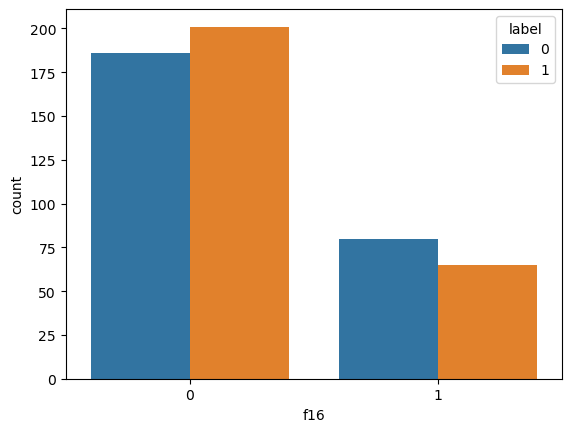

In [46]:
# сгруппируем данные по значению фактора f16 ('Нелогичный выбор сферы бизнеса') - горизонтальная ось 
# и по метке прибыльности/неприбыльности заёма - оранжевый/синий цвета, соотв.
sns.countplot(x='f16',hue='label',data=DF)

видно по графику, что некая зависимость наблюдается.
если профит высок (label=1), то фактор f16 чаще равен 1, нежели 0
и наоборот если профит низок (label=0), фактор f16 чаще равен 0

<Axes: xlabel='f1', ylabel='count'>

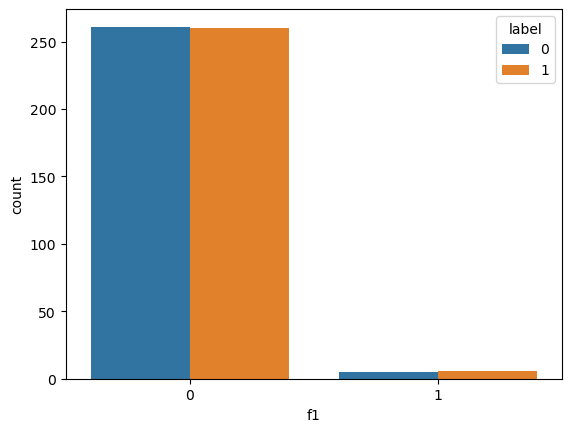

In [47]:
# проделаем то же самое для всех фич
# feature f1 ('учредителю подсказывают / на ВИ другой человек') 
sns.countplot(x='f1',hue='label',data=DF)

<Axes: xlabel='f19', ylabel='count'>

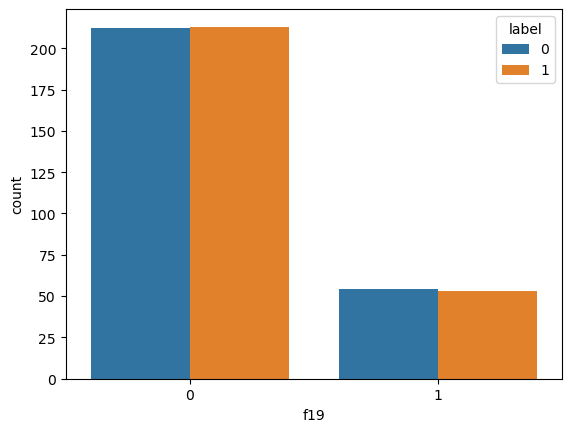

In [48]:
# feature f19 ('Есть "партнер", который официально не оформлен') 
sns.countplot(x='f19',hue='label',data=DF)

фичи f1 и f19 не вносят вклад в разделение данных на две категории, посколько в обоих случаях (и для "хороших" и для "плохих" займов)
имеют практически одинаковую частоту  
то же самое справедливо и для фич f12, f13, f21

In [49]:
# создадим еще один датасет уже без "ненужных" факторов:
x3 = DF.drop(columns=['Loan issued','rating','Comission, %', 'Earned interest',
       'Unpaid,  full amount', 'EL','loss', 'InvestorProfit', 'Profit',
       'Profit,%', 'label',
       'f1','f12','f13','f19','f21',
        #'f7','f11','f14','f15'
                     ],axis=1)
y3 = DF['label']                   

In [50]:
# splitting data to train, test and check 
x_check3 = x3[-15:]
y_check3 = y3[-15:]
X3 = x3[:-15]
Y3 = y3[:-15]

X_train3, X_test3,Y_train3,Y_test3 = train_test_split(X3,Y3,test_size=0.1,stratify=Y3,random_state=2)
print(X_train3.shape, X_test3.shape,x_check3.shape)

(465, 18) (52, 18) (15, 18)


In [51]:
#SVM

In [52]:
sv3 = svm.SVC(kernel='linear')
sv3.fit(X_train3,Y_train3)

SVC(kernel='linear')

In [53]:
# accuracy score on training data
X_train_pred_sv3 = sv3.predict(X_train3)
train_accuracy_sv3 = accuracy_score(X_train_pred_sv3,Y_train3)
print('Accuracy on training data : ', train_accuracy_sv3)

Accuracy on training data :  0.6387096774193548


In [54]:
# accuracy score on test data
X_test_pred_sv3 = sv3.predict(X_test3)
test_accuracy_sv3 = accuracy_score(X_test_pred_sv3,Y_test3)
print('Accuracy on test data : ', test_accuracy_sv3)

Accuracy on test data :  0.6153846153846154


In [55]:
#linear regression

In [56]:
lr3 = LogisticRegression()
lr3.fit(X_train3,Y_train3)

LogisticRegression()

In [57]:
# accuracy score on training data
X_train_pred_lr3 = lr3.predict(X_train3)
train_accuracy_lr3 = accuracy_score(X_train_pred_lr3,Y_train3)
print('Accuracy on training data : ', train_accuracy_lr3)

Accuracy on training data :  0.6473118279569893


In [58]:
# accuracy score on test data
X_test_pred_sv3 = sv3.predict(X_test3)
test_accuracy_sv3 = accuracy_score(X_test_pred_sv3,Y_test3)
print('Accuracy on test data : ', test_accuracy_sv3)

Accuracy on test data :  0.6153846153846154


обе модели (и svm, и logistic regression) повысили свою точность после преобразований

In [60]:
# попробуем построить сверточную нейросеть CNN

In [61]:
import keras
from keras import preprocessing
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding
from tensorflow.keras import layers

In [65]:
inputs = keras.Input(shape=(18,1))
x = layers.BatchNormalization()(inputs)


x = layers.Conv1D(filters=18, kernel_size=4, padding="same", activation='relu')(x) # слой свертки
x = layers.Dense(18, activation='relu')(x)
x = layers.Dense(6, activation='relu')(x)

x = layers.Flatten()(x)
x = layers.Dropout(0.2)(x)

outputs = keras.layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="classification-model")
model.summary()

Model: "classification-model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 18, 1)]           0         
                                                                 
 batch_normalization_1 (Batc  (None, 18, 1)            4         
 hNormalization)                                                 
                                                                 
 conv1d_1 (Conv1D)           (None, 18, 18)            90        
                                                                 
 dense_3 (Dense)             (None, 18, 18)            342       
                                                                 
 dense_4 (Dense)             (None, 18, 6)             114       
                                                                 
 flatten_1 (Flatten)         (None, 108)               0         
                                              

In [66]:
model.compile(loss='mse',optimizer='sgd',metrics=['accuracy'])

In [67]:
fit_results = model.fit(x=X_train3,y=Y_train3,epochs=100,validation_split=0.2)

Epoch 1/100
12/12 [==============================] - 1s 21ms/step - loss: 0.2520 - accuracy: 0.4758 - val_loss: 0.2476 - val_accuracy: 0.5484
Epoch 2/100
12/12 [==============================] - 0s 5ms/step - loss: 0.2527 - accuracy: 0.4543 - val_loss: 0.2476 - val_accuracy: 0.5376
Epoch 3/100
12/12 [==============================] - 0s 5ms/step - loss: 0.2519 - accuracy: 0.4919 - val_loss: 0.2475 - val_accuracy: 0.5591
Epoch 4/100
12/12 [==============================] - 0s 4ms/step - loss: 0.2511 - accuracy: 0.4919 - val_loss: 0.2475 - val_accuracy: 0.5591
Epoch 5/100
12/12 [==============================] - 0s 5ms/step - loss: 0.2509 - accuracy: 0.4919 - val_loss: 0.2474 - val_accuracy: 0.5699
Epoch 6/100
12/12 [==============================] - 0s 5ms/step - loss: 0.2484 - accuracy: 0.5108 - val_loss: 0.2473 - val_accuracy: 0.5806
Epoch 7/100
12/12 [==============================] - 0s 5ms/step - loss: 0.2499 - accuracy: 0.4946 - val_loss: 0.2471 - val_accuracy: 0.5914
Epoch 8/100


Модель глубокого обучения показала в этой задаче себя хуже, чем логистическая регрессия.
Остановимся на последней (3-ей) модели логистической регрессии с метриками: Accuracy on training data = 0.6473, Accuracy on test data =  0.6153.

В будущем можно попробовать более глубоко изучить все факторы, и возможно, убрать большинство из них.
Также среди данных не хватает числовых значений, например, выручки компании заёмщика за последние несколько лет; 
или количества сотрудников, работающих в компании; наличия данных о семейном положении, о наличии недвижимости, принадлежащей компании и т.д.
